In [1]:
# import numpy and pandas
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%config Completer.use_jedi=False
import os

#import sklearn for cross validation|
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score,cross_validate

#import keras modules
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import keras.backend.tensorflow_backend as KTF
import keras
import keras.layers
from keras.layers import Layer 
import keras.initializers
from keras.models import Model, Sequential,load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Embedding, Lambda, Flatten, Multiply, multiply,dot, add,subtract
from keras.layers import Concatenate,concatenate,LeakyReLU,maximum,minimum
from keras.optimizers import Adam
from keras.regularizers import l2,l1
from keras.preprocessing import sequence
from keras.engine.topology import Layer, InputSpec

from keras.utils import plot_model
from IPython.display import SVG


from sklearn.metrics import precision_recall_curve, auc, roc_curve

#import rdkit
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols

#fix the random seed
np.random.seed(5)

import pickle
import random



Using TensorFlow backend.


In [2]:
GeneExpression_with_Symbol=pd.read_csv('/DAS_Storage4/ijjin/Study_2/CellLine/CCLE_expression_zscore.csv',index_col=0)
valid_gene_list=GeneExpression_with_Symbol.columns

In [3]:
GeneSet_List=[]
GeneSetFile='/DAS_Storage1/ijjin/Personal_studies/Drug-Cancer_reponse/geneset/c2.cp.kegg.v7.5.1.symbols.gmt'
with open(GeneSetFile) as f:
    reader = csv.reader(f)
    data = list(list(rec) for rec in csv.reader(f, delimiter='\t')) #reads csv into a list of lists
    for row in data:
        GeneSet_List.append(row)

GeneSet_Dic={}
for GeneSet in GeneSet_List:
    GeneSet_Dic[GeneSet[0]]=GeneSet[2:]
GeneSet_Dic_withoutNA={}
for GeneSet in GeneSet_Dic:
    GeneSet_tmp=pd.Series(GeneSet_Dic[GeneSet])
    GeneSet_tmp=GeneSet_tmp[GeneSet_tmp.isin(valid_gene_list)]
    GeneSet_Dic_withoutNA[GeneSet]=GeneSet_tmp




In [4]:
NCI60=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/221031_NCI60_median_with_raw_parameter.csv',index_col=0)

In [5]:
NCI60

,NSC,CellName,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope
0,1,786O,-2.0,1.916247,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
1,1,786O,-1.0,2.006393,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
2,1,786O,0.0,2.069248,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
3,1,786O,1.0,2.066457,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
4,1,786O,2.0,0.079399,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
...,...,...,...,...,...,...,...,...,...,...
4737369,783538,UACC62,-4.0,1.966015,2.040921,5,2.042580,3.025320e-01,-1.727939,2.277316
4737370,783538,UACC62,-3.0,2.040921,2.040921,5,2.042580,3.025320e-01,-1.727939,2.277316
4737371,783538,UACC62,-2.0,1.398113,2.040921,5,2.042580,3.025320e-01,-1.727939,2.277316
4737372,783538,UACC62,-1.0,0.613998,2.040921,5,2.042580,3.025320e-01,-1.727939,2.277316


In [6]:
NCI60_randomized=NCI60.sample(frac=1)
NCI60_randomized=NCI60_randomized.reset_index(drop=True)

<AxesSubplot:xlabel='AVERAGE_GIPRCNT', ylabel='Density'>

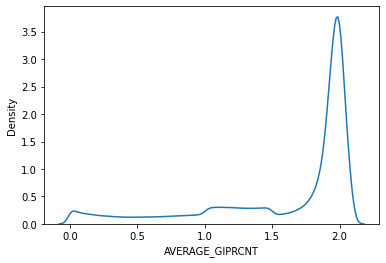

In [7]:
sns.kdeplot(NCI60_randomized.AVERAGE_GIPRCNT)

In [8]:
NCI60_randomized_level_list=[]
scale=0.1
for i in range(int(2/scale)):
    NCI60_randomized_level_df=NCI60_randomized[(NCI60_randomized.AVERAGE_GIPRCNT>i*scale)*(NCI60_randomized.AVERAGE_GIPRCNT<(i+1)*scale)]
    NCI60_randomized_level_list.append(NCI60_randomized_level_df)
len_min=min([len(df) for df in NCI60_randomized_level_list])
NCI60_randomized_level_list_new=[]
for df in NCI60_randomized_level_list:
    scale_each=len_min/len(df)
    df_new=df.sample(frac=scale_each)
    NCI60_randomized_level_list_new.append(df_new)
NCI60_balanced=pd.concat(NCI60_randomized_level_list_new)

<AxesSubplot:xlabel='AVERAGE_GIPRCNT', ylabel='Density'>

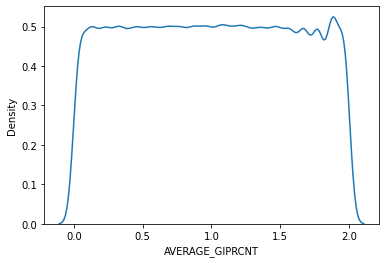

In [9]:
sns.kdeplot(NCI60_balanced.AVERAGE_GIPRCNT)

In [10]:
NCI60_randomized=NCI60_balanced.sample(frac=1)

<AxesSubplot:xlabel='y_max', ylabel='Density'>

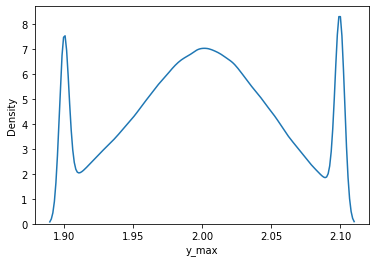

In [11]:
sns.kdeplot(NCI60_balanced.y_max)

<AxesSubplot:xlabel='y_min', ylabel='Density'>

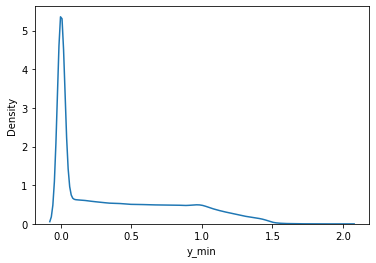

In [12]:
sns.kdeplot(NCI60_balanced.y_min)

<AxesSubplot:xlabel='IC50', ylabel='Density'>

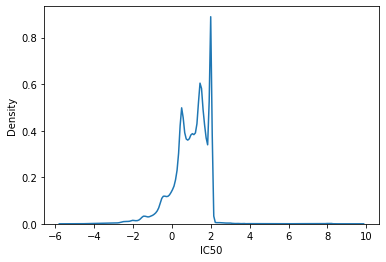

In [13]:
sns.kdeplot(NCI60_balanced.IC50)

<AxesSubplot:xlabel='slope', ylabel='Density'>

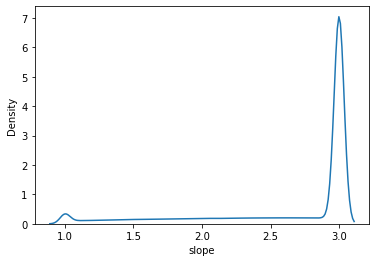

In [14]:
sns.kdeplot(NCI60_balanced.slope)

In [7]:
K.clear_session()
def get_session(gpu_fraction=0.1):

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    return tf.Session(config=tf.ConfigProto(allow_soft_placement=True,gpu_options=gpu_options))

KTF.set_session(get_session())


2022-11-07 13:13:10.034797: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-11-07 13:13:10.071778: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299915000 Hz
2022-11-07 13:13:10.076384: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5464940 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-07 13:13:10.076456: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-11-07 13:13:10.082412: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-07 13:13:10.182884: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x24f76fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-07 13:13:10.182953: I tensorflow/compiler/xla/service/se

In [8]:
X_origin=[pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/CellLine/Input/'+str(x)+'.csv',index_col=0) for x in range(len(GeneSet_Dic_withoutNA))]
Drug=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Drug/NCI60_compound_Morgan512.csv',index_col=0)


In [9]:
NCI60_filtered=NCI60_randomized

In [10]:
def pick_up_balanced(df,ratio_list,filter_list):
    #df: NCI60_filtered
    #ratio: [training_ratio,validation_ratio,test_ratio]
    #filter_list: [] (empty): Unseen combination (Drug-Cell line-Concentration)/['NSC','CellName']: Unseen Pair/['NSC']: Unseen Drug/['CellName']: Unseen Cell line
    if sum(ratio_list)!=1:
        ratio_list=[0.8,0.1,0.1]
        
    if len(filter_list)==0:
        test_Response_list=range(0,int(len(NCI60_filtered)*1/10))
        training_Response_list=range(int(len(NCI60_filtered)*1/10),int(len(NCI60_filtered)*9/10))
        validation_Response_list=range(int(len(NCI60_filtered)*9/10),(len(NCI60_filtered)))
        return [test_Response_list,training_Response_list,validation_Response_list]
    
    else:
        identifier_df=NCI60_filtered[filter_list+['CONCENTRATION']].groupby(by=filter_list).count().reset_index()
        identifier_df.columns=filter_list+['count']
        identifier_df=identifier_df.sort_values(by='count')
        len_df=len(identifier_df)

        test_idx=np.arange(0,len_df,10)
        training_idx=[]
        for i in np.arange(1,9,1):
            training_idx.extend(np.arange(i,len_df,10))
        training_idx=np.sort(training_idx)
        validation_idx=np.arange(9,len_df,10)

        test_pair_df=identifier_df.iloc[test_idx]
        training_pair_df=identifier_df.iloc[training_idx]
        validation_pair_df=identifier_df.iloc[validation_idx]

        NCI60_filtered_with_index=NCI60_filtered[filter_list].reset_index()

        test_df=pd.merge(test_pair_df,NCI60_filtered_with_index,how='inner',on=filter_list)
        training_df=pd.merge(training_pair_df,NCI60_filtered_with_index,how='inner',on=filter_list)
        validation_df=pd.merge(validation_pair_df,NCI60_filtered_with_index,how='inner',on=filter_list)

        test_Response_list=test_df['index']
        training_Response_list=training_df['index']
        validation_Response_list=validation_df['index']


        return [test_Response_list,training_Response_list,validation_Response_list]

In [11]:
#Unseen Combination
test_Response_list,training_Response_list,validation_Response_list=pick_up_balanced(NCI60_filtered,[0.8,0.1,0.1],[])

In [12]:
#relu
def Making_Model():
    #model_parameter=load_model('/DAS_Storage4/ijjin/Study_2/Single/NCI60_March22/Parameter/Model/220507_training_validation.hdf5',compile=False)

    #Make Model for each gene set, that consists of multiple genes_attention by built-in(2019/05/08)
    initializer = tf.keras.initializers.he_uniform()

    #Drug level
    Drug_feature_length=512
    Drug_Input=Input((Drug_feature_length,), dtype='float32', name='Drug_Input')
    Drug_Input=Input((Drug_feature_length,), dtype='float32')

    Drug_Dense1=Dense(256, name='Drug_Dense_1',kernel_initializer=initializer)(Drug_Input)
    Drug_Dense1=BatchNormalization()(Drug_Dense1)
    Drug_Dense1=Activation('relu', name='Drug_RELU_1')(Drug_Dense1)

    Drug_Dense2=Dense(128, name='Drug_Dense_2',kernel_initializer=initializer)(Drug_Dense1)
    Drug_Dense2=BatchNormalization()(Drug_Dense2)
    Drug_Dense2=Activation('relu', name='Drug_RELU_2')(Drug_Dense2)

    Drug_Dense_New1=Dense(128, name='Drug_Dense_New1',kernel_initializer=initializer)(Drug_Input)
    Drug_Dense_New1=BatchNormalization()(Drug_Dense_New1)
    Drug_Dense_New1=Activation('relu', name='Drug_RELU_New1')(Drug_Dense_New1)

    Drug_Dense_New2=Dense(32, name='Drug_Dense_New2',kernel_initializer=initializer)(Drug_Dense_New1)
    Drug_Dense_New2=BatchNormalization()(Drug_Dense_New2)
    Drug_Dense_New2=Activation('relu', name='Drug_RELU_New2')(Drug_Dense_New2)
    
    #Gene level
    GeneSet_Model=[]
    GeneSet_Input=[]
    for GeneSet in GeneSet_Dic_withoutNA.keys():
        Gene_Input=Input(shape=(len(GeneSet_Dic_withoutNA[GeneSet]),),dtype='float32', name=GeneSet+'_Input')
        
        Drug_effected_Model_for_Attention=[Gene_Input]
        Drug_Dense_Geneset=Dense(int(len(GeneSet_Dic_withoutNA[GeneSet])/4)+1,dtype='float32',name=GeneSet+'_Drug',kernel_initializer=initializer)(Drug_Dense_New2)
        Drug_Dense_Geneset=BatchNormalization(name=GeneSet+'_Drug_Batch')(Drug_Dense_Geneset)
        Drug_Dense_Geneset=Activation('relu', name=GeneSet+'Drug_RELU')(Drug_Dense_Geneset)
        Drug_effected_Model_for_Attention.append(Drug_Dense_Geneset) #Drug feature to attention layer
        Gene_Concat=concatenate(Drug_effected_Model_for_Attention,axis=1,name=GeneSet+'_Concat')
        Gene_Attention = Dense(len(GeneSet_Dic_withoutNA[GeneSet]), activation='tanh', name=GeneSet+'_Attention_Dense',kernel_initializer=initializer)(Gene_Concat)
        Gene_Attention=Activation(activation='softmax', name=GeneSet+'_Attention_Softmax')(Gene_Attention)
        Attention_Dot=dot([Gene_Input,Gene_Attention],axes=1,name=GeneSet+'_Dot')
        Attention_Dot=BatchNormalization(name=GeneSet+'_BatchNormalized')(Attention_Dot)
        Attention_Dot=Activation('relu',name=GeneSet+'_RELU')(Attention_Dot)
        GeneSet_Model.append(Attention_Dot)
        GeneSet_Input.append(Gene_Input)

    Drug_effected_Model_for_Attention=GeneSet_Model.copy()
    
    
    Drug_Dense_Sample=Dense(int(len(GeneSet_Dic_withoutNA)/16)+1,dtype='float32',name='Sample_Drug_Dense',kernel_initializer=initializer)(Drug_Dense_New2)
    Drug_Dense_Sample=BatchNormalization(name=GeneSet+'Sample_Drug_Batch')(Drug_Dense_Sample)
    Drug_Dense_Sample=Activation('relu', name='Sample_Drug_ReLU')(Drug_Dense_Sample)    #Drug feature to attention layer
    Drug_effected_Model_for_Attention.append(Drug_Dense_Sample)
    
    GeneSet_Concat=concatenate(GeneSet_Model,axis=1, name='GeneSet_Concatenate')
    Drug_effected_Concat=concatenate(Drug_effected_Model_for_Attention,axis=1, name='Drug_effected_Concatenate')
    Sample_Attention=Dense(len(GeneSet_Dic_withoutNA.keys()),activation='tanh', name='Sample_Attention_Dense',kernel_initializer=initializer)(Drug_effected_Concat)
    Sample_Attention=Activation(activation='softmax', name='Sample_Attention_Softmax')(Sample_Attention)
    Sample_Multiplied=multiply([GeneSet_Concat,Sample_Attention], name='Sample_Attention_Multiplied')
    Sample_Multiplied=BatchNormalization(name='Sample_Attention_BatchNormalized')(Sample_Multiplied)
    Sample_Multiplied=Activation('relu',name='Sample_Attention_Relu')(Sample_Multiplied)
    
    Input_for_model=[]
    for GeneSet_f in GeneSet_Input:
        Input_for_model.append(GeneSet_f)
    Input_for_model.append(Drug_Input)
    
    Dose_Input=Input((1,), dtype='float32', name='Dose_Input')
    Input_for_model.append(Dose_Input)

    Total_model=[Sample_Multiplied,Drug_Dense2]
    Model_Concat=concatenate(Total_model,axis=1, name='Total_Concatenate')
    Concated=Dense(128, name='Total_Dense')(Model_Concat)
    Concated=BatchNormalization(name='Total_BatchNormalized')(Concated)
    Concated=Activation(activation='relu', name='Total_RELU')(Concated)
    
    Final=Dense(32, name='Output_Dense1',kernel_initializer=initializer)(Concated)
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU')(Final)
    Final=Dense(8,name='Output_Dense2',kernel_initializer=initializer)(Final)
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU2')(Final)
    Final=Dense(2, name='Output_Dense3',kernel_initializer=initializer)(Final)    
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU3')(Final)
    
    Final_y_max=Dense(1, name='y_max',kernel_initializer=initializer)(Final)
    Final_y_min=Dense(1, name='y_min',kernel_initializer=initializer)(Final)
    Final_slope=Dense(1, name='slope',kernel_initializer=initializer)(Final)
    Final_IC50=Dense(1, name='IC50',kernel_initializer=initializer)(Final)

    Final_1=subtract([Dose_Input,Final_IC50],name='Final_1')
    Final_2=multiply([Final_slope,Final_1],name='Final_2')
    Final_negative=Lambda(lambda x:-1*x)(Final_2)
    Final_Sigmoid=Activation(activation='sigmoid',name='Final_Sigmoid')(Final_negative)
    Final_scale=subtract([Final_y_max,Final_y_min],name='Final_scale')
    Final_scale=Activation(activation='relu',name='Final_scale_activation')(Final_scale)
    Final_3=multiply([Final_scale,Final_Sigmoid],name='Final_3')
    Final_4=add([Final_3,Final_y_min],name='Final_4')
    model=Model(inputs=Input_for_model,outputs=Final_4)

    return model


In [13]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0005, factor=0.1, patience=10, min_lr=0, verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0.0005, restore_best_weights=True)


In [14]:
class HiDRA_DataGenerator(keras.utils.Sequence):
    def __init__(self, idxs, batch_size=1024, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.idxs = idxs
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.idxs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        idxs_tmp = [self.idxs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(idxs_tmp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.idxs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs_tmp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        # Generate data
        NCI60_float_gen=NCI60_filtered.iloc[idxs_tmp]
        X_origin_tmp=[df.loc[NCI60_float_gen['CellName']] for df in X_origin]
        X_origin_tmp.append(Drug.loc[NCI60_float_gen['NSC']])
        Dose_df=pd.DataFrame(NCI60_float_gen['CONCENTRATION'])
        X_origin_tmp.append(Dose_df)
        Y_origin_tmp=NCI60_float_gen['AVERAGE_GIPRCNT']

        return X_origin_tmp, Y_origin_tmp

In [15]:
NCI60_filtered=NCI60_filtered.reset_index(drop=True)

In [16]:
training_generator=HiDRA_DataGenerator(training_Response_list)
validation_generator=HiDRA_DataGenerator(validation_Response_list)
test_generator=HiDRA_DataGenerator(test_Response_list)

In [17]:
def plcc_loss(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - r 

def aggregated_loss(y_true,y_pred):
    mse_value=tf.keras.metrics.mse(y_true,y_pred)
    pearson_loss=plcc_loss(y_true,y_pred)
    return mse_value+pearson_loss
    
    
def plcc_metric(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    return r_num / r_den


In [29]:
NCI60_filtered.iloc[test_Response_list].to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Training/Split_by_Combination/Split_by_Combination_Test.csv')

In [31]:
NCI60_filtered.iloc[training_Response_list].to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Training/Split_by_Combination/Split_by_Pair_Training.csv')

In [32]:
NCI60_filtered.iloc[validation_Response_list].to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Training/Split_by_Combination/Split_by_Pair_Validation.csv')

In [18]:
#test
model2=Making_Model()
model2.compile(loss=aggregated_loss,optimizer=keras.optimizers.Adam(lr=0.01),metrics=[plcc_metric,'mean_squared_error'])


In [19]:
NCI60_filtered

,NSC,CellName,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope
0,4518,KM12,1.0000,1.034569,2.049053,5,2.099319,8.219485e-01,-0.278687,3.000000
1,674102,UACC257,-2.0000,1.952976,1.952976,5,1.912630,1.000310e-01,1.030786,2.092798
2,666660,OVCAR4,-2.0000,2.040612,2.078281,5,2.079099,3.622170e-17,1.283848,3.000000
3,699491,NIHOVCAR3,1.3979,1.071269,1.996271,12,1.976040,2.916764e-01,0.074183,1.000000
4,701758,786O,0.0000,2.026348,2.026348,5,1.978109,1.325838e+00,1.626795,3.000000
...,...,...,...,...,...,...,...,...,...,...
4737369,147811,HCT116,-2.0000,2.024697,2.078496,5,2.081552,6.362993e-01,0.525233,1.960788
4737370,732731,NIHOVCAR3,-2.0000,1.978422,1.978422,5,1.998067,8.412381e-31,1.550210,3.000000
4737371,689184,A498,2.0000,1.332236,2.096231,5,2.003508,6.697522e-01,2.000000,3.000000
4737372,660812,KM12,0.0000,1.990000,2.022000,5,2.013793,1.427302e+00,1.033655,3.000000


In [ ]:
#New dataset(GIPRCNT) on New model with MinMax_Training whole dataset (y_max=2)
hist=model2.fit_generator(generator=training_generator, steps_per_epoch=len(training_Response_list) // 1024, epochs=2000,verbose=1,validation_data=validation_generator,use_multiprocessing=True,workers=10,callbacks=[reduce_lr,es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2000






2022-11-07 13:23:34.902930: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


3701/3701 [==============================] - 3772s 1s/step - loss: 0.2366 - plcc_metric: 0.8602 - mean_squared_error: 0.0968 - val_loss: 0.1460 - val_plcc_metric: 0.9099 - val_mean_squared_error: 0.0559
Epoch 2/2000
3701/3701 [==============================] - 3542s 957ms/step - loss: 0.1216 - plcc_metric: 0.9251 - mean_squared_error: 0.0468 - val_loss: 0.1127 - val_plcc_metric: 0.9306 - val_mean_squared_error: 0.0433
Epoch 3/2000
3701/3701 [==============================] - 3829s 1s/step - loss: 0.1062 - plcc_metric: 0.9348 - mean_squared_error: 0.0410 - val_loss: 0.1005 - val_plcc_metric: 0.9381 - val_mean_squared_error: 0.0387
Epoch 4/2000
3701/3701 [==============================] - 3745s 1s/step - loss: 0.0970 - plcc_metric: 0.9405 - mean_squared_error: 0.0375 - val_loss: 0.0942 - val_plcc_metric: 0.9423 - val_mean_squared_error: 0.0365
Epoch 5/2000
3701/3701 [==============================] - 3343s 903ms/step - loss: 0.0916 - plcc_metric: 0.9438 - mean_squared_error: 0.0355 - val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3105/3701 [========================>.....] - ETA: 9:21 - loss: 0.0830 - plcc_metric: 0.9492 - mean_squared_error: 0.0322

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3806s 1s/step - loss: 0.0813 - plcc_metric: 0.9503 - mean_squared_error: 0.0316 - val_loss: 0.0844 - val_plcc_metric: 0.9481 - val_mean_squared_error: 0.0325
Epoch 10/2000
2397/3701 [==================>...........] - ETA: 21:21 - loss: 0.0797 - plcc_metric: 0.9513 - mean_squared_error: 0.0309

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3809s 1s/step - loss: 0.0782 - plcc_metric: 0.9522 - mean_squared_error: 0.0304 - val_loss: 0.0812 - val_plcc_metric: 0.9502 - val_mean_squared_error: 0.0313
Epoch 12/2000
1494/3701 [===========>..................] - ETA: 36:11 - loss: 0.0765 - plcc_metric: 0.9532 - mean_squared_error: 0.0297

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3355s 906ms/step - loss: 0.0761 - plcc_metric: 0.9535 - mean_squared_error: 0.0296 - val_loss: 0.0806 - val_plcc_metric: 0.9507 - val_mean_squared_error: 0.0313
Epoch 14/2000
 653/3701 [====>.........................] - ETA: 43:31 - loss: 0.0738 - plcc_metric: 0.9549 - mean_squared_error: 0.0287

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3466/3701 [===========================>..] - ETA: 3:18 - loss: 0.0744 - plcc_metric: 0.9545 - mean_squared_error: 0.0289

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3288s 888ms/step - loss: 0.0738 - plcc_metric: 0.9549 - mean_squared_error: 0.0287 - val_loss: 0.0795 - val_plcc_metric: 0.9514 - val_mean_squared_error: 0.0309
Epoch 17/2000
1106/3701 [=======>......................] - ETA: 36:49 - loss: 0.0721 - plcc_metric: 0.9559 - mean_squared_error: 0.0280

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2770/3701 [=====================>........] - ETA: 13:13 - loss: 0.0729 - plcc_metric: 0.9554 - mean_squared_error: 0.0284

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3285s 888ms/step - loss: 0.0726 - plcc_metric: 0.9557 - mean_squared_error: 0.0282 - val_loss: 0.0790 - val_plcc_metric: 0.9516 - val_mean_squared_error: 0.0306
Epoch 19/2000
 384/3701 [==>...........................] - ETA: 47:25 - loss: 0.0701 - plcc_metric: 0.9572 - mean_squared_error: 0.0273

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1907/3701 [==============>...............] - ETA: 25:18 - loss: 0.0717 - plcc_metric: 0.9562 - mean_squared_error: 0.0279

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3304/3701 [=========================>....] - ETA: 5:35 - loss: 0.0716 - plcc_metric: 0.9563 - mean_squared_error: 0.0279

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1269/3701 [=========>....................] - ETA: 34:12 - loss: 0.0703 - plcc_metric: 0.9570 - mean_squared_error: 0.0273

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3276s 885ms/step - loss: 0.0707 - plcc_metric: 0.9568 - mean_squared_error: 0.0275 - val_loss: 0.0772 - val_plcc_metric: 0.9526 - val_mean_squared_error: 0.0298
Epoch 23/2000
3701/3701 [==============================] - 3622s 979ms/step - loss: 0.0703 - plcc_metric: 0.9571 - mean_squared_error: 0.0274 - val_loss: 0.0778 - val_plcc_metric: 0.9527 - val_mean_squared_error: 0.0305
Epoch 24/2000
3701/3701 [==============================] - 3746s 1s/step - loss: 0.0699 - plcc_metric: 0.9574 - mean_squared_error: 0.0272 - val_loss: 0.0772 - val_plcc_metric: 0.9529 - val_mean_squared_error: 0.0301
Epoch 25/2000
3701/3701 [==============================] - 3535s 955ms/step - loss: 0.0695 - plcc_metric: 0.9576 - mean_squared_error: 0.0271 - val_loss: 0.0769 - val_plcc_metric: 0.9528 - val_mean_squared_error: 0.0297
Epoch 26/2000
3701/3701 [==============================] - 3109s 840ms/step - loss: 0.0692 - plcc_metric: 0.9578 - mean_squared_error: 0.

In [ ]:
pd.DataFrame(hist.history).to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Full_by_Combination_Training_and_Validation.csv')

In [44]:
model2.save('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_Combination/221107_Trained_Model.hdf5')

In [22]:
model2.evaluate_generator(test_generator)

[0.07285252269115541, 0.9553202917049457, 0.02817281469041522]

In [23]:
test_idx=test_generator.indexes
predicted_tmp=model2.predict_generator(test_generator)
predicted_tmp=[x[0] for x in predicted_tmp]

In [24]:
test_idx_df=pd.DataFrame({'idx':test_Response_list})
test_idx_new=test_idx_df.iloc[test_idx].idx.values

In [25]:
test_df=NCI60_filtered.iloc[test_idx_new]
test_df=test_df.iloc[0:len(predicted_tmp)]

In [26]:
test_df['predicted']=predicted_tmp

In [33]:
test_df.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_Combination/221107_test_df.csv')

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


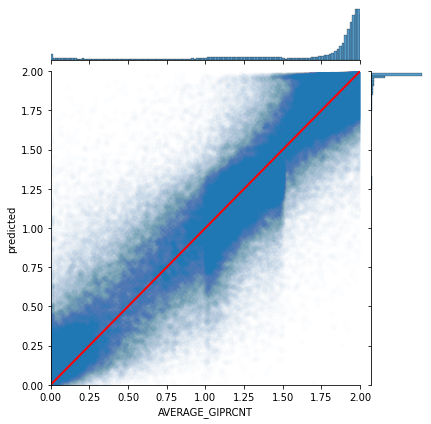

In [34]:
#new
plot=sns.jointplot(test_df.AVERAGE_GIPRCNT,test_df.predicted,alpha=0.01)
plot.ax_joint.set_xlim(0,2)
plot.ax_joint.set_ylim(0,2)
plot.ax_joint.plot([0,2], [0,2], 'r', linewidth = 2)
plot.savefig('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_Combination/221108_NCI60_Split_by_Combination_full.pdf')

In [28]:
test_df.corr()

,NSC,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope,predicted
NSC,1.000000,-0.007733,0.051909,0.040373,-0.162326,-0.015147,0.017999,0.090948,0.038939,0.053988
CONCENTRATION,-0.007733,1.000000,-0.688748,-0.000343,-0.044721,0.001248,-0.009841,0.133311,0.013979,-0.709533
AVERAGE_GIPRCNT,0.051909,-0.688748,1.000000,0.108789,-0.046031,-0.030635,0.127754,0.240954,0.032244,0.955351
Viability_max,0.040373,-0.000343,0.108789,1.000000,0.012193,0.679910,-0.058879,0.164761,0.141465,0.054916
count,-0.162326,-0.044721,-0.046031,0.012193,1.000000,-0.025325,0.042735,-0.207010,-0.146666,-0.045737
y_max,-0.015147,0.001248,-0.030635,0.679910,-0.025325,1.000000,-0.069181,-0.213134,0.020299,-0.077611
y_min,0.017999,-0.009841,0.127754,-0.058879,0.042735,-0.069181,1.000000,-0.237570,-0.096954,0.095199
IC50,0.090948,0.133311,0.240954,0.164761,-0.207010,-0.213134,-0.237570,1.000000,0.090709,0.227378
slope,0.038939,0.013979,0.032244,0.141465,-0.146666,0.020299,-0.096954,0.090709,1.000000,0.010380
predicted,0.053988,-0.709533,0.955351,0.054916,-0.045737,-0.077611,0.095199,0.227378,0.010380,1.000000


In [35]:
NCI60_randomized_level_list=[]
scale=0.1
for i in range(int(2/scale)):
    NCI60_randomized_level_df=test_df[(test_df.AVERAGE_GIPRCNT>i*scale)*(test_df.AVERAGE_GIPRCNT<(i+1)*scale)]
    NCI60_randomized_level_list.append(NCI60_randomized_level_df)
len_min=min([len(df) for df in NCI60_randomized_level_list])
NCI60_randomized_level_list_new=[]
for df in NCI60_randomized_level_list:
    scale_each=len_min/len(df)
    df_new=df.sample(frac=scale_each)
    NCI60_randomized_level_list_new.append(df_new)
NCI60_balanced=pd.concat(NCI60_randomized_level_list_new)

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


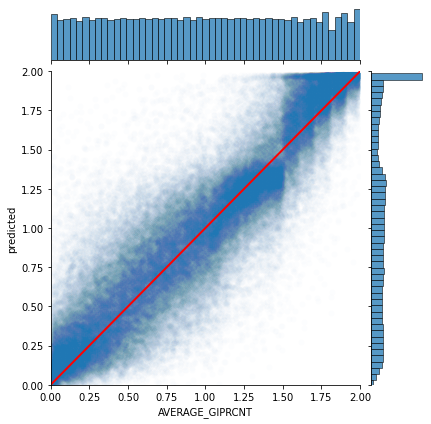

In [36]:
#new_scaled
plot=sns.jointplot(NCI60_balanced.AVERAGE_GIPRCNT,NCI60_balanced.predicted,alpha=0.01)
plot.ax_joint.set_xlim(0,2)
plot.ax_joint.set_ylim(0,2)
plot.ax_joint.plot([0,2], [0,2], 'r', linewidth = 2)
plot.savefig('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_Combination/221108_NCI60_Split_by_Combination_scaled.pdf')

In [37]:
test_df.corr()

,NSC,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope,predicted
NSC,1.000000,-0.007733,0.051909,0.040373,-0.162326,-0.015147,0.017999,0.090948,0.038939,0.053988
CONCENTRATION,-0.007733,1.000000,-0.688748,-0.000343,-0.044721,0.001248,-0.009841,0.133311,0.013979,-0.709533
AVERAGE_GIPRCNT,0.051909,-0.688748,1.000000,0.108789,-0.046031,-0.030635,0.127754,0.240954,0.032244,0.955351
Viability_max,0.040373,-0.000343,0.108789,1.000000,0.012193,0.679910,-0.058879,0.164761,0.141465,0.054916
count,-0.162326,-0.044721,-0.046031,0.012193,1.000000,-0.025325,0.042735,-0.207010,-0.146666,-0.045737
y_max,-0.015147,0.001248,-0.030635,0.679910,-0.025325,1.000000,-0.069181,-0.213134,0.020299,-0.077611
y_min,0.017999,-0.009841,0.127754,-0.058879,0.042735,-0.069181,1.000000,-0.237570,-0.096954,0.095199
IC50,0.090948,0.133311,0.240954,0.164761,-0.207010,-0.213134,-0.237570,1.000000,0.090709,0.227378
slope,0.038939,0.013979,0.032244,0.141465,-0.146666,0.020299,-0.096954,0.090709,1.000000,0.010380
predicted,0.053988,-0.709533,0.955351,0.054916,-0.045737,-0.077611,0.095199,0.227378,0.010380,1.000000


In [38]:
model_parameter=Model(inputs=model2.inputs,outputs=[model2.get_layer('y_max').output,model2.get_layer('y_min').output,model2.get_layer('IC50').output,model2.get_layer('slope').output])

In [39]:
test_idx=test_generator.indexes
test_parameter=model_parameter.predict_generator(test_generator)
test_y_max=[x[0] for x in test_parameter[0]]
test_y_min=[x[0] for x in test_parameter[1]]
test_IC50=[x[0] for x in test_parameter[2]]
test_slope=[x[0] for x in test_parameter[3]]
test_idx_df=pd.DataFrame({'idx':test_Response_list})
test_idx_new=test_idx_df.iloc[test_idx].idx.values
test_df=NCI60_filtered.iloc[test_idx_new]
test_df=test_df.iloc[0:len(predicted_tmp)]
test_df['y_max_predicted']=test_y_max
test_df['y_min_predicted']=test_y_min
test_df['IC50_predicted']=test_IC50
test_df['slope_predicted']=test_slope

In [40]:
def response(x,y_max,y_min,IC50,slope):
    return (y_min+((y_max-y_min)/(1+np.exp(slope*(x-IC50)))))

#The function for the response curve

In [41]:
test_df['predicted_from_parameter']=[response(x.CONCENTRATION,x.y_max_predicted,x.y_min_predicted,x.IC50_predicted,x.slope_predicted) for idx,x in test_df.iterrows()]

In [42]:
test_df.corr()

,NSC,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope,y_max_predicted,y_min_predicted,IC50_predicted,slope_predicted,predicted_from_parameter
NSC,1.000000,-0.007779,0.051982,0.040387,-0.162253,-0.015155,0.018049,0.090952,0.038916,-0.058605,0.041278,0.113704,0.012509,0.054032
CONCENTRATION,-0.007779,1.000000,-0.688671,-0.000246,-0.044837,0.001349,-0.009821,0.133575,0.014064,-0.037872,0.019760,0.067581,0.011662,-0.709470
AVERAGE_GIPRCNT,0.051982,-0.688671,1.000000,0.108774,-0.045989,-0.030652,0.127726,0.240882,0.032227,-0.087226,0.157881,0.251487,-0.031287,0.955340
Viability_max,0.040387,-0.000246,0.108774,1.000000,0.012273,0.679910,-0.058755,0.164716,0.141327,-0.173132,-0.049655,0.189551,0.125747,0.054903
count,-0.162253,-0.044837,-0.045989,0.012273,1.000000,-0.025284,0.042634,-0.206875,-0.146829,0.218742,0.039848,-0.259009,-0.147031,-0.045671
y_max,-0.015155,0.001349,-0.030652,0.679910,-0.025284,1.000000,-0.069119,-0.213056,0.020190,0.016407,-0.162518,-0.160584,0.074612,-0.077656
y_min,0.018049,-0.009821,0.127726,-0.058755,0.042634,-0.069119,1.000000,-0.237616,-0.096975,0.555160,0.716541,-0.132489,-0.691600,0.095158
IC50,0.090952,0.133575,0.240882,0.164716,-0.206875,-0.213056,-0.237616,1.000000,0.090721,-0.583578,0.043372,0.818664,0.314808,0.227306
slope,0.038916,0.014064,0.032227,0.141327,-0.146829,0.020190,-0.096975,0.090721,1.000000,-0.354769,-0.296809,0.222054,0.358605,0.010365
y_max_predicted,-0.058605,-0.037872,-0.087226,-0.173132,0.218742,0.016407,0.555160,-0.583578,-0.354769,1.000000,0.665941,-0.771485,-0.922492,-0.090480


In [43]:
test_df.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_Combination/221107_test_df_by_parameter.csv')